# Exchange rates

Задачей данного проекта является предсказание курса валюты USD/EURO.Помимо работы с данными и подбора моделей,хотел продемонстрировать возможность сбора информации с помощью библиотеки BS4

## Парсинг

### Импортируем все библиотеки

In [1]:
import pandas as pd
from IPython.display import display
from bs4 import BeautifulSoup
import requests
import csv
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
import catboost as catboost
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor

Напишем функцию для прохода вглубь сайта.Данная функция нужна,поскольку структура сайта,с которого я решил парсить не позволяет сделать по-другому

In [2]:
def parser_one_page(period,find_name,element):
    href='https://www.calc.ru'+period['href']
    url=requests.get(href)
    parser=BeautifulSoup(url.text,"lxml")
    table=parser.find(class_=find_name).find_all(element)
    return table

С помощью вышеуказанной функции сделаем функцию,которая будет формировать готовую для работы таблицу

In [3]:
def parsing_to_tab(link,filename):
    result=requests.get(link)
    parser=BeautifulSoup(result.text,"lxml")
    year_table=parser.find(class_="result_table").find_all("a")
    for year in year_table:
        month_table=parser_one_page(year,"result_table","a")
        for month in month_table:
            day_table=parser_one_page(month,"result_table","td")
            for day in range(0, len(day_table), 2):
                with open(filename,"a") as file:
                    writer=csv.writer(file)
                    writer.writerow((day_table[day].text.strip(),day_table[day + 1].text.strip()))

In [4]:
# parsing_to_tab("https://www.calc.ru/kotirovka-dollar-ssha.html","dollar.csv")
# parsing_to_tab("https://www.calc.ru/kotirovka-yevro.html","euro.csv")

После использования функции получаем две таблицы,дял доллара и евро.Преобразуем для дальнейшей работы таблицы,сделав даты инексами.Затем проверим на монотонность

In [5]:
dollar=pd.read_csv("dollar.csv",sep=";",parse_dates=[0],index_col=[0])
dollar.dropna(axis=0,inplace=True)
dollar.sort_index(inplace=True)
display(dollar.head(5))
print(dollar.index.is_monotonic)
print(dollar.info())

,Price
Date,
1992-01-07,134.8
1992-01-08,161.2
1992-01-09,210.5
1992-01-10,309.0
1992-01-11,398.0


True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10814 entries, 1992-01-07 to 2022-12-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   10814 non-null  float64
dtypes: float64(1)
memory usage: 169.0 KB
None


In [6]:
euro=pd.read_csv("euro.csv",sep=";",parse_dates=[0],index_col=[0])
euro.dropna(axis=0,inplace=True)
euro.sort_index(inplace=True)
display(euro.head(5))
print(dollar.index.is_monotonic)
print(euro.info())

,Price
Date,
1998-12-30,24.09
1998-12-31,24.09
1999-01-01,24.09
1999-01-02,25.86
1999-01-03,25.17


True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8471 entries, 1998-12-30 to 2022-12-03
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   8471 non-null   float64
dtypes: float64(1)
memory usage: 132.4 KB
None


Как видим,данные успешно подготовлены к работе

## Предобработка 

In [7]:
print(dollar.index.min())
print(dollar.index.max())
print(dollar.index.max()-dollar.index.min())

1992-01-07 00:00:00
2022-12-03 00:00:00
11288 days 00:00:00


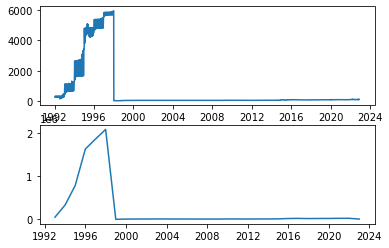

In [8]:
plt.subplot(211)
plt.plot(dollar.rolling(5).mean());
plt.subplot(212)
plt.plot(dollar.resample('1Y').sum());

In [9]:
print(euro.index.min())
print(euro.index.max())
print(euro.index.max()-euro.index.min())

1998-12-30 00:00:00
2022-12-03 00:00:00
8739 days 00:00:00


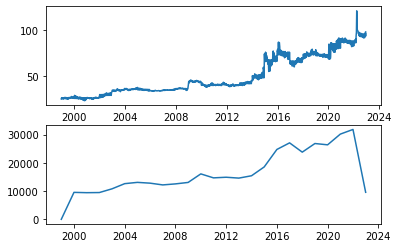

In [10]:
plt.subplot(211)
plt.plot(euro.rolling(10).mean());
plt.subplot(212)
plt.plot(euro.resample('1Y').sum());

Выше мы видим распределения курса по годам,полученное с помощью расемплирования(суммируем значения за год,смотрим на сумму). Также вывели график скользящего среднего

Напишем функцию,для разложение ряда не тренд,сезонность и остаток,принимающую на вход название теблицы,ак также период,по которому требуется найти вышеперечисленные составляющие

In [11]:
def decomposition(table,period_from,period_to):
    analysis=table[period_from:period_to]
    print(analysis.index.max()-analysis.index.min())
    plt.figure(figsize=(12,10))
    decomposed = seasonal_decompose(analysis)
    plt.subplot(311)
    plt.title('Trend')
    decomposed.trend.plot(ax=plt.gca())
    plt.subplot(312)
    plt.title('Sesonal')
    decomposed.seasonal.plot(ax=plt.gca())
    plt.subplot(313)
    plt.title('Resid')
    decomposed.resid.plot(ax=plt.gca())

Возьмем,например,данные за 2004 год по доллару:

365 days 00:00:00


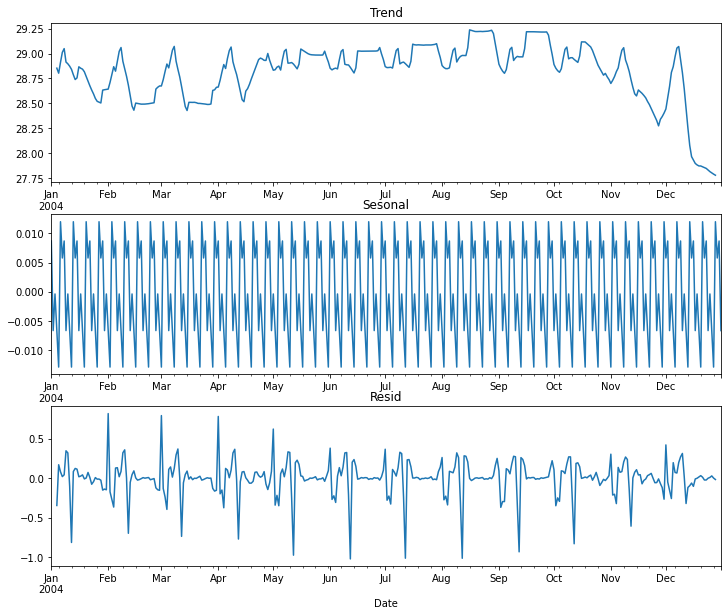

In [12]:
decomposition(dollar,'2004-01','2004-12')

Или для евро за 2004:

365 days 00:00:00


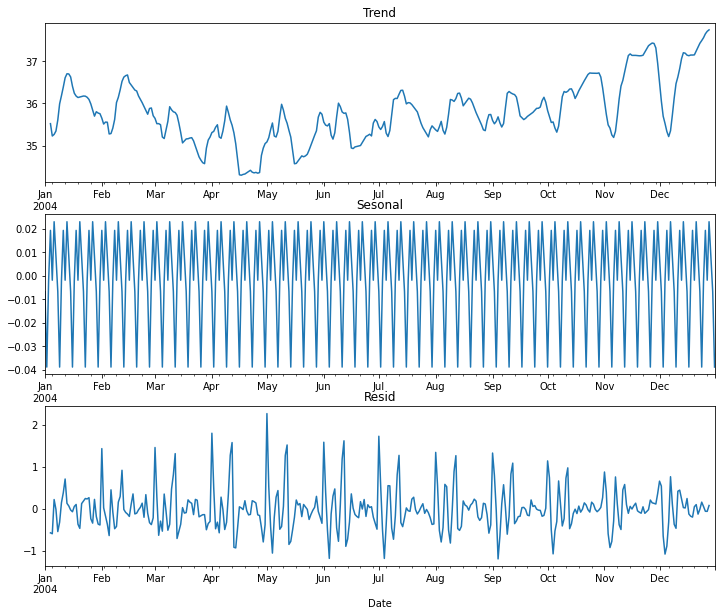

In [13]:
decomposition(euro,'2004-01','2004-12')

## Обучение и тестирование

In [14]:
def make_features(table,max_lag,roll):
    table['year']=table.index.year
    table['month']=table.index.month
    table['rolling_mean']=table['Price'].rolling(roll).mean()
    table['dayofweek']=table.index.dayofweek
    for i in range(1,max_lag+1):
        table['lag_{}'.format(i)]=table['Price'].shift(i)
    table=table.dropna()
    return table

In [15]:
dollar_final=make_features(dollar,20,100)
display(dollar_final)
print(dollar_final.info())

,Price,year,month,rolling_mean,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
Date,,,,,,,,,,,,,,,,,,,,,
1992-09-18,205.5000,1992,9,223.407200,4,205.5000,205.5000,204.0000,204.0000,203.0000,...,130.3000,210.5000,205.0000,205.0000,205.0000,205.0000,205.0000,168.1000,168.1000,162.6000
1992-09-19,205.5000,1992,9,224.114200,5,205.5000,205.5000,205.5000,204.0000,204.0000,...,161.5000,130.3000,210.5000,205.0000,205.0000,205.0000,205.0000,205.0000,168.1000,168.1000
1992-09-20,205.5000,1992,9,224.557200,6,205.5000,205.5000,205.5000,205.5000,204.0000,...,203.0000,161.5000,130.3000,210.5000,205.0000,205.0000,205.0000,205.0000,205.0000,168.1000
1992-09-21,241.0000,1992,9,224.862200,0,205.5000,205.5000,205.5000,205.5000,205.5000,...,334.0000,203.0000,161.5000,130.3000,210.5000,205.0000,205.0000,205.0000,205.0000,205.0000
1992-09-22,241.0000,1992,9,224.182200,1,241.0000,205.5000,205.5000,205.5000,205.5000,...,403.0000,334.0000,203.0000,161.5000,130.3000,210.5000,205.0000,205.0000,205.0000,205.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-03,120.3785,2022,11,85.391654,3,74.7241,75.1315,74.8501,116.0847,74.8015,...,82.5962,105.8124,75.6806,74.2926,83.3520,105.8124,76.0509,74.2926,83.5932,105.8124
2022-11-04,74.8501,2022,11,85.405196,4,120.3785,74.7241,75.1315,74.8501,116.0847,...,74.2926,82.5962,105.8124,75.6806,74.2926,83.3520,105.8124,76.0509,74.2926,83.5932
2022-12-01,74.8355,2022,12,85.417037,3,74.8501,120.3785,74.7241,75.1315,74.8501,...,75.3042,74.2926,82.5962,105.8124,75.6806,74.2926,83.3520,105.8124,76.0509,74.2926


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10715 entries, 1992-09-18 to 2022-12-03
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         10715 non-null  float64
 1   year          10715 non-null  int64  
 2   month         10715 non-null  int64  
 3   rolling_mean  10715 non-null  float64
 4   dayofweek     10715 non-null  int64  
 5   lag_1         10715 non-null  float64
 6   lag_2         10715 non-null  float64
 7   lag_3         10715 non-null  float64
 8   lag_4         10715 non-null  float64
 9   lag_5         10715 non-null  float64
 10  lag_6         10715 non-null  float64
 11  lag_7         10715 non-null  float64
 12  lag_8         10715 non-null  float64
 13  lag_9         10715 non-null  float64
 14  lag_10        10715 non-null  float64
 15  lag_11        10715 non-null  float64
 16  lag_12        10715 non-null  float64
 17  lag_13        10715 non-null  float64
 18  lag_14   

In [16]:
euro_final=make_features(euro,20,100)
display(euro_final)
print(euro_final.info())

,Price,year,month,rolling_mean,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
Date,,,,,,,,,,,,,,,,,,,,,
1999-04-08,26.0400,1999,4,25.828800,3,24.8700,25.1000,25.6700,26.7500,25.0000,...,26.2600,26.2600,26.2600,26.3300,26.4200,26.4600,26.0000,25.9600,25.9600,25.9600
1999-04-09,27.6100,1999,4,25.864000,4,26.0400,24.8700,25.1000,25.6700,26.7500,...,26.0200,26.2600,26.2600,26.2600,26.3300,26.4200,26.4600,26.0000,25.9600,25.9600
1999-04-10,27.3200,1999,4,25.896300,5,27.6100,26.0400,24.8700,25.1000,25.6700,...,25.9400,26.0200,26.2600,26.2600,26.2600,26.3300,26.4200,26.4600,26.0000,25.9600
1999-04-11,27.5300,1999,4,25.930700,6,27.3200,27.6100,26.0400,24.8700,25.1000,...,25.9200,25.9400,26.0200,26.2600,26.2600,26.2600,26.3300,26.4200,26.4600,26.0000
1999-04-12,26.7800,1999,4,25.939900,0,27.5300,27.3200,27.6100,26.0400,24.8700,...,24.0900,25.9200,25.9400,26.0200,26.2600,26.2600,26.2600,26.3300,26.4200,26.4600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-02,85.3798,2022,11,95.027909,2,85.1315,81.7064,126.4395,85.3784,84.0695,...,115.6212,86.5181,84.0695,91.7289,115.6212,87.1163,84.0695,92.3872,115.6212,87.1163
2022-11-03,132.9581,2022,11,95.528127,3,85.3798,85.1315,81.7064,126.4395,85.3784,...,90.5998,115.6212,86.5181,84.0695,91.7289,115.6212,87.1163,84.0695,92.3872,115.6212
2022-12-01,84.8784,2022,12,95.544717,3,132.9581,85.3798,85.1315,81.7064,126.4395,...,84.0695,90.5998,115.6212,86.5181,84.0695,91.7289,115.6212,87.1163,84.0695,92.3872


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8372 entries, 1999-04-08 to 2022-12-03
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Price         8372 non-null   float64
 1   year          8372 non-null   int64  
 2   month         8372 non-null   int64  
 3   rolling_mean  8372 non-null   float64
 4   dayofweek     8372 non-null   int64  
 5   lag_1         8372 non-null   float64
 6   lag_2         8372 non-null   float64
 7   lag_3         8372 non-null   float64
 8   lag_4         8372 non-null   float64
 9   lag_5         8372 non-null   float64
 10  lag_6         8372 non-null   float64
 11  lag_7         8372 non-null   float64
 12  lag_8         8372 non-null   float64
 13  lag_9         8372 non-null   float64
 14  lag_10        8372 non-null   float64
 15  lag_11        8372 non-null   float64
 16  lag_12        8372 non-null   float64
 17  lag_13        8372 non-null   float64
 18  lag_14    

Далее напишем большую функцию,для деления датасета на обучающие и тестовые выборки,подбора гиперпараметров,результата подбора:

In [17]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
RMSE_score = make_scorer(RMSE, greater_is_better=False)# соственный скорер указывает на то,что лучшее значение является наименьшим 

In [24]:
def make_predictions(table):
    #Делим на тестовую и обучающую выборки
    train,test=train_test_split(table,test_size=0.1,shuffle=False)
    train_features=train.drop(['Price'],axis=1)
    train_target=train['Price']
    test_features=test.drop(['Price'],axis=1)
    test_target=test['Price']
    #Подбор параметров 
    print("ПОДБОР ПАРАМЕТРОВ:\n")
    print("DECISION TREE:\n")
    my_cv_tree = TimeSeriesSplit(n_splits=3).split(train_features)#поскольку,для предсказания временных рядов,перемешивать данные нельзя,используется алгоритм TimeSeriesSplit
    tree = DecisionTreeRegressor()
    parametrs_tree = {'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }
    tree_grid = GridSearchCV(tree,parametrs_tree, scoring=RMSE_score, cv=my_cv_tree)
    tree_grid.fit(train_features,train_target)
    print("Лучшие параметры дерева: ",tree_grid.best_params_)
    print()
    
    print("RANDOM FOREST: \n")
    my_cv_forest = TimeSeriesSplit(n_splits=3).split(train_features)
    forest = RandomForestRegressor()
    parametrs_forest = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 15, 2),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }
    forest_grid = GridSearchCV(forest,parametrs_forest, scoring=RMSE_score, cv=my_cv_forest)
    forest_grid.fit(train_features, train_target)
    print("Лучшие параметры леса: ",forest_grid.best_params_)
    print()
    
    print("CATBOOST: \n")
    my_cv_cb = TimeSeriesSplit(n_splits=3).split(train_features)
    cb = catboost.CatBoostRegressor()
    parametrs_cb = { 'learning_rate': [0.03,0.1],
                     'depth': [2,4,6,8,10] }
    cb_grid = GridSearchCV(cb,parametrs_cb, scoring=RMSE_score, cv=my_cv_cb)
    cb_grid.fit(train_features, train_target,verbose=False)
    print("Лучшие параметры CatBoost: ",cb_grid.best_params_)
    print()
    
    #Тест
    print("LINEAR REGRESSION\n")
    regression=LinearRegression(normalize=True)
    regression.fit(train_features,train_target)
    regression_predict=regression.predict(test_features)
    mse_regression=mean_squared_error(test_target,regression_predict)
    print('MSE для регрессии: ',mse_regression)
    
    print("DECISION TREE\n")
    tree_final = DecisionTreeRegressor(**tree_grid.best_params_)
    tree_final.fit(train_features,train_target)
    tree_final_predict=tree_final.predict(test_features)
    mse_tree_final=mean_squared_error(test_target,tree_final_predict)
    print('MSE для дерева: ',mse_tree_final)
    
    print("RANDOM FOREST\n")
    forest_final=RandomForestRegressor(**forest_grid.best_params_)
    forest_final.fit(train_features,train_target)
    forest_final_predict=forest_final.predict(test_features)
    mse_forest_final=mean_squared_error(test_target,forest_final_predict)
    print('MSE для леса: ',mse_forest_final)
    
    print("CATBOOST\n")
    cb_final=catboost.CatBoostRegressor(**cb_grid.best_params_)
    cb_final.fit(train_features,train_target,verbose=False)
    cb_predict=cb_final.predict(test_features)
    mse_cb=mean_squared_error(test_target,cb_predict)
    print('MSE для catboost: ',mse_cb)

In [22]:
make_predictions(dollar_final)

ПОДБОР ПАРАМЕТРОВ:

DECISION TREE:

Лучшие параметры дерева:  {'max_depth': 13, 'min_samples_leaf': 4, 'min_samples_split': 4}

RANDOM FOREST: 

Лучшие параметры леса:  {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 15}

CATBOOST: 

Лучшие параметры CatBoost:  {'depth': 4, 'learning_rate': 0.1}

LINEAR REGRESSION

MSE для регрессии:  31.51073883591309
DECISION TREE

MSE для дерева:  32.700707439419226
RANDOM FOREST

MSE для леса:  25.203552484245005
CATBOOST

MSE для catboost:  75.87676696633804


,model,score


Как видно,лучший результат показывает модель случайного леса,с MSE=25.2

In [23]:
make_predictions(euro_final)

ПОДБОР ПАРАМЕТРОВ:

DECISION TREE:

Лучшие параметры дерева:  {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 6}

RANDOM FOREST: 

Лучшие параметры леса:  {'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 5}

CATBOOST: 

Лучшие параметры CatBoost:  {'depth': 2, 'learning_rate': 0.1}

LINEAR REGRESSION

MSE для регрессии:  34.38197508998732
DECISION TREE

MSE для дерева:  135.15877428820272
RANDOM FOREST

MSE для леса:  68.58786307669784
CATBOOST

MSE для catboost:  85.91833810949605


,model,score


Для евро же результат оказался другим. Линейная регрессия показала наилучший результат(34.4).Такое различие по результату других алгоритмов,помимо регрессии,объясняется тем,что данных оказалось мало для должного обучения.

# Вывод

Основной целью проекта являлось создание модели,предсказывающей курс доллара и евро,выраженного в рублях.Для сбора данных была написана функция,принимающая на вход ссылку на раздел сайта calc.ru,возвращающая датасет.Во время предварительного анализа была написана функцию,разлогающая датасет на сезонную составляющую,также была продемонстрирована данны составляющая на 2004 год.Для перехода к машинному обучению требовалось разложить дату на дополнительные признаки,затем добавить логи и скользящее среднее,для создания дополнительных признаков.Результаты работы модели показали следующее MSE: для доллара(25.2), для евро(34.4).